### Imports

In [1]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import math
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

# Leitura do ficheiro

In [2]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

In [3]:
file = data_folder / "EventosFinalComClusterConcelhos.feather"
QuebrasFinal = pd.read_feather(file)
QuebrasFinal

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,t_min,dd_med,dd_ffx,ff_med,ff_max,pr_qtd,Cluster_Arredores das Grandes cidades,Cluster_Grandes Cidades,Cluster_Interior,Cluster_Litoral e ZonasIndustrias
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,55,828,0.002935,0.000044,0.002456,...,2.6,278.25,289.5,2.0,7.8,0.0,1,0,0,0
1,EDPD_2018_JUN_T_20,ALMADA,2018-06-15,MT,Escavações,262,2657,0.006267,0.000044,0.008009,...,15.5,345.00,351.0,4.3,14.3,0.0,1,0,0,0
2,EDPD_2018_AGO_T_44,ALMADA,2018-08-30,MT,Escavações,97,3657,0.005956,0.000055,0.003870,...,15.8,340.00,2.0,2.2,9.0,0.0,1,0,0,0
3,EDPD_2018_SET_T_50,ALMADA,2018-09-10,MT,Escavações,63,3009,0.006319,0.000077,0.004607,...,16.4,5.00,331.0,2.6,9.1,0.0,1,0,0,0
4,EDPD_2021_JAN_T_9,ALMADA,2021-01-08,MT,Inundações Imprevisíveis,583,1962,0.009740,0.000030,0.008560,...,3.8,9.00,1.0,3.8,12.4,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,EDPD_2020_MAI_T_33,MIRANDADODOURO,2020-05-21,MT,Intervenções À Superficie,153,827,0.012402,0.000140,0.017559,...,12.6,216.00,163.0,2.0,10.9,0.0,0,0,1,0
2918,EDPD_2020_JUL_T_9,FIGUEIRADECASTELORODRIGO,2020-07-11,MT,Descarga Atmosférica Directa,323,65,0.008296,0.000118,0.024722,...,14.9,41.00,272.0,3.6,20.1,4.4,0,0,1,0
2919,EDPD_2020_AGO_T_26,FIGUEIRADECASTELORODRIGO,2020-08-27,MT,Aves,21,3,0.000032,0.000011,0.000222,...,15.3,307.00,295.0,5.7,13.8,0.0,0,0,1,0
2920,EDPD_2020_AGO_T_14,SERNANCELHE,2020-08-06,MT,Risco Iminente Pessoas Ou Bens,287,525,0.004722,0.000086,0.016253,...,20.0,309.00,281.0,3.4,9.4,0.0,0,0,1,0


In [4]:
QuebrasFinal.columns

Index(['codigo_do_relatorio', 'concelho', 'data_do_incidente',
       'nivel_de_tensao', 'causa_do_incidente', 'duracao_incidente_min_',
       'n_º_clientes_afetados', 'tiepi_mt_min_', 'saifi_mt_#_',
       'saidi_mt_min_', 'end_mwh_', 'saifi_bt_#_', 'saidi_bt_min_', 'decisao',
       'distrito', 'classe_da_causa_4', 'classe_da_causa_6', 'sen_ano',
       'cos_ano', 'sen_mes', 'cos_mes', 't_med', 't_max', 't_min', 'dd_med',
       'dd_ffx', 'ff_med', 'ff_max', 'pr_qtd',
       'Cluster_Arredores das Grandes cidades', 'Cluster_Grandes Cidades',
       'Cluster_Interior', 'Cluster_Litoral e ZonasIndustrias'],
      dtype='object')

## Criação de Variáveis

### Tipo de tensão

In [5]:
QuebrasFinal["Ser_BT?"] = np.where(QuebrasFinal["nivel_de_tensao"] == "BT", 1, 0)
QuebrasFinal

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,dd_med,dd_ffx,ff_med,ff_max,pr_qtd,Cluster_Arredores das Grandes cidades,Cluster_Grandes Cidades,Cluster_Interior,Cluster_Litoral e ZonasIndustrias,Ser_BT?
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,55,828,0.002935,0.000044,0.002456,...,278.25,289.5,2.0,7.8,0.0,1,0,0,0,0
1,EDPD_2018_JUN_T_20,ALMADA,2018-06-15,MT,Escavações,262,2657,0.006267,0.000044,0.008009,...,345.00,351.0,4.3,14.3,0.0,1,0,0,0,0
2,EDPD_2018_AGO_T_44,ALMADA,2018-08-30,MT,Escavações,97,3657,0.005956,0.000055,0.003870,...,340.00,2.0,2.2,9.0,0.0,1,0,0,0,0
3,EDPD_2018_SET_T_50,ALMADA,2018-09-10,MT,Escavações,63,3009,0.006319,0.000077,0.004607,...,5.00,331.0,2.6,9.1,0.0,1,0,0,0,0
4,EDPD_2021_JAN_T_9,ALMADA,2021-01-08,MT,Inundações Imprevisíveis,583,1962,0.009740,0.000030,0.008560,...,9.00,1.0,3.8,12.4,0.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,EDPD_2020_MAI_T_33,MIRANDADODOURO,2020-05-21,MT,Intervenções À Superficie,153,827,0.012402,0.000140,0.017559,...,216.00,163.0,2.0,10.9,0.0,0,0,1,0,0
2918,EDPD_2020_JUL_T_9,FIGUEIRADECASTELORODRIGO,2020-07-11,MT,Descarga Atmosférica Directa,323,65,0.008296,0.000118,0.024722,...,41.00,272.0,3.6,20.1,4.4,0,0,1,0,0
2919,EDPD_2020_AGO_T_26,FIGUEIRADECASTELORODRIGO,2020-08-27,MT,Aves,21,3,0.000032,0.000011,0.000222,...,307.00,295.0,5.7,13.8,0.0,0,0,1,0,0
2920,EDPD_2020_AGO_T_14,SERNANCELHE,2020-08-06,MT,Risco Iminente Pessoas Ou Bens,287,525,0.004722,0.000086,0.016253,...,309.00,281.0,3.4,9.4,0.0,0,0,1,0,0


### Dummies Causas Acidentes

In [6]:
ColDummies = "classe_da_causa_4"

# Criar variáveis dummy
dummies = pd.get_dummies(QuebrasFinal[ColDummies])

# Converter as variáveis dummy de booleanas para int
dummies = dummies.astype(int)

# Concatenar as variáveis dummy ao DataFrame original
QuebrasFinal = pd.concat([QuebrasFinal, dummies], axis=1)

# Excluir a coluna original "Grande Classe"
QuebrasFinal.drop(["classe_da_causa_4", "classe_da_causa_6"], axis=1, inplace=True)

# Exibir o DataFrame com as variáveis dummy convertidas para int
QuebrasFinal

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,pr_qtd,Cluster_Arredores das Grandes cidades,Cluster_Grandes Cidades,Cluster_Interior,Cluster_Litoral e ZonasIndustrias,Ser_BT?,Animais,Clima,Humanos - Acidentes,Humanos - Intenção
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,55,828,0.002935,0.000044,0.002456,...,0.0,1,0,0,0,0,0,0,1,0
1,EDPD_2018_JUN_T_20,ALMADA,2018-06-15,MT,Escavações,262,2657,0.006267,0.000044,0.008009,...,0.0,1,0,0,0,0,0,0,1,0
2,EDPD_2018_AGO_T_44,ALMADA,2018-08-30,MT,Escavações,97,3657,0.005956,0.000055,0.003870,...,0.0,1,0,0,0,0,0,0,1,0
3,EDPD_2018_SET_T_50,ALMADA,2018-09-10,MT,Escavações,63,3009,0.006319,0.000077,0.004607,...,0.0,1,0,0,0,0,0,0,1,0
4,EDPD_2021_JAN_T_9,ALMADA,2021-01-08,MT,Inundações Imprevisíveis,583,1962,0.009740,0.000030,0.008560,...,0.0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,EDPD_2020_MAI_T_33,MIRANDADODOURO,2020-05-21,MT,Intervenções À Superficie,153,827,0.012402,0.000140,0.017559,...,0.0,0,0,1,0,0,0,0,1,0
2918,EDPD_2020_JUL_T_9,FIGUEIRADECASTELORODRIGO,2020-07-11,MT,Descarga Atmosférica Directa,323,65,0.008296,0.000118,0.024722,...,4.4,0,0,1,0,0,0,1,0,0
2919,EDPD_2020_AGO_T_26,FIGUEIRADECASTELORODRIGO,2020-08-27,MT,Aves,21,3,0.000032,0.000011,0.000222,...,0.0,0,0,1,0,0,1,0,0,0
2920,EDPD_2020_AGO_T_14,SERNANCELHE,2020-08-06,MT,Risco Iminente Pessoas Ou Bens,287,525,0.004722,0.000086,0.016253,...,0.0,0,0,1,0,0,0,0,1,0


## Estandardizar/Normalizar os dados

In [7]:
QuebrasFinal.dtypes

codigo_do_relatorio                              object
concelho                                         object
data_do_incidente                        datetime64[ns]
nivel_de_tensao                                category
causa_do_incidente                             category
duracao_incidente_min_                            int32
n_º_clientes_afetados                             int32
tiepi_mt_min_                                   float64
saifi_mt_#_                                     float64
saidi_mt_min_                                   float64
end_mwh_                                        float64
saifi_bt_#_                                     float64
saidi_bt_min_                                   float64
decisao                                        category
distrito                                         object
sen_ano                                         float64
cos_ano                                         float64
sen_mes                                         

In [8]:
QuebrasFinal["duracao_incidente_min_"] = QuebrasFinal["duracao_incidente_min_"].astype(int)


# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas

Index(['duracao_incidente_min_', 'n_º_clientes_afetados', 'tiepi_mt_min_',
       'saifi_mt_#_', 'saidi_mt_min_', 'end_mwh_', 'saifi_bt_#_',
       'saidi_bt_min_', 'sen_ano', 'cos_ano', 'sen_mes', 'cos_mes', 't_med',
       't_max', 't_min', 'dd_med', 'dd_ffx', 'ff_med', 'ff_max', 'pr_qtd',
       'Cluster_Arredores das Grandes cidades', 'Cluster_Grandes Cidades',
       'Cluster_Interior', 'Cluster_Litoral e ZonasIndustrias', 'Ser_BT?',
       'Animais', 'Clima', 'Humanos - Acidentes', 'Humanos - Intenção'],
      dtype='object')

In [9]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,pr_qtd,Cluster_Arredores das Grandes cidades,Cluster_Grandes Cidades,Cluster_Interior,Cluster_Litoral e ZonasIndustrias,Ser_BT?,Animais,Clima,Humanos - Acidentes,Humanos - Intenção
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,-0.274064,-0.069411,-0.036605,-0.038730,-0.035542,...,-0.403032,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641
1,EDPD_2018_JUN_T_20,ALMADA,2018-06-15,MT,Escavações,0.163957,-0.018786,-0.034361,-0.038733,-0.032607,...,-0.403032,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641
2,EDPD_2018_AGO_T_44,ALMADA,2018-08-30,MT,Escavações,-0.185190,0.008894,-0.034570,-0.038378,-0.034795,...,-0.403032,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641
3,EDPD_2018_SET_T_50,ALMADA,2018-09-10,MT,Escavações,-0.257136,-0.009043,-0.034326,-0.037660,-0.034405,...,-0.403032,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641
4,EDPD_2021_JAN_T_9,ALMADA,2021-01-08,MT,Inundações Imprevisíveis,0.843209,-0.038023,-0.032023,-0.039195,-0.032316,...,-0.403032,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,2.697707,-0.983032,-0.222641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,EDPD_2020_MAI_T_33,MIRANDADODOURO,2020-05-21,MT,Intervenções À Superficie,-0.066692,-0.069439,-0.030230,-0.035614,-0.027559,...,-0.403032,-0.313183,-0.231803,1.418581,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641
2918,EDPD_2020_JUL_T_9,FIGUEIRADECASTELORODRIGO,2020-07-11,MT,Descarga Atmosférica Directa,0.293036,-0.090531,-0.032995,-0.036323,-0.023773,...,0.118092,-0.313183,-0.231803,1.418581,-1.057067,-0.391884,-0.718573,2.697707,-0.983032,-0.222641
2919,EDPD_2020_AGO_T_26,FIGUEIRADECASTELORODRIGO,2020-08-27,MT,Aves,-0.346010,-0.092247,-0.038560,-0.039822,-0.036722,...,-0.403032,-0.313183,-0.231803,1.418581,-1.057067,-0.391884,1.391648,-0.370685,-0.983032,-0.222641
2920,EDPD_2020_AGO_T_14,SERNANCELHE,2020-08-06,MT,Risco Iminente Pessoas Ou Bens,0.216859,-0.077798,-0.035402,-0.037374,-0.028250,...,-0.403032,-0.313183,-0.231803,1.418581,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641


## Outliers

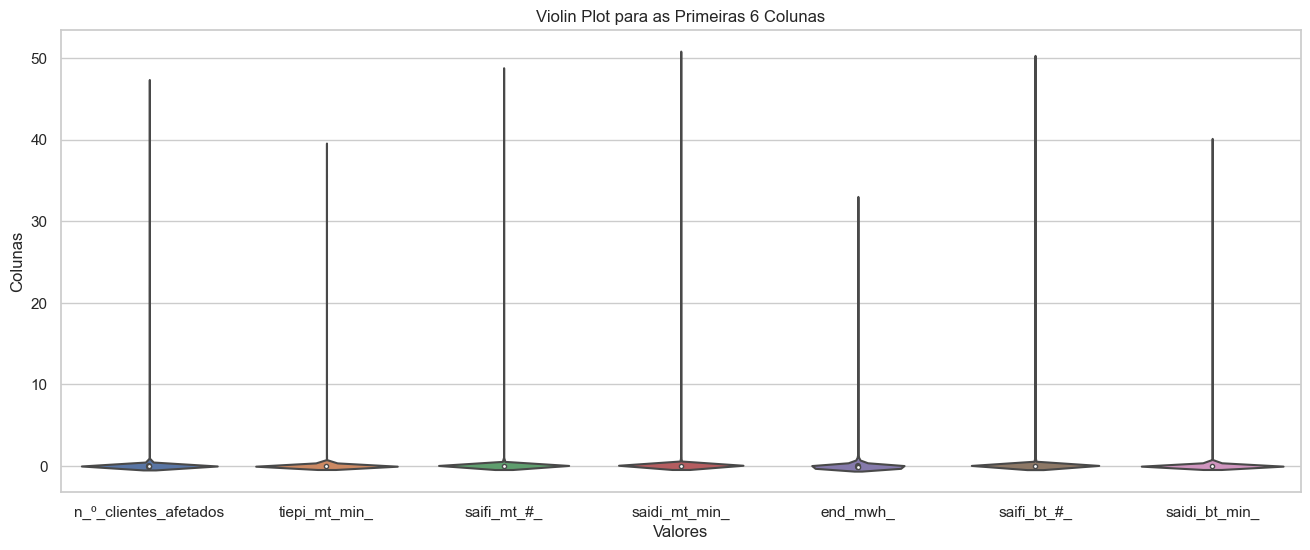

In [10]:
sns.set(style="whitegrid")

ColunasInteresse = ['n_º_clientes_afetados', 'tiepi_mt_min_', 'saifi_mt_#_', 'saidi_mt_min_', 'end_mwh_', 'saifi_bt_#_', 'saidi_bt_min_']

# Obter os índices das colunas numéricas
indices_col_numericas = [QuebrasFinal.columns.get_loc(col) for col in ColunasInteresse]

# Selecionar as colunas numéricas utilizando os índices
subset_quebras_final = QuebrasFinal.iloc[:, indices_col_numericas]

# Plotar violin plot para as primeiras 6 colunas
plt.figure(figsize=(16, 6))
sns.violinplot(data=subset_quebras_final)
plt.title("Violin Plot para as Primeiras 6 Colunas")
plt.xlabel("Valores")
plt.ylabel("Colunas")
plt.show()

In [11]:
# Selecionar as colunas específicas
colunas_outliers = ['n_º_clientes_afetados', 'tiepi_mt_min_', 'saifi_mt_#_', 'saidi_mt_min_', 'end_mwh_', 'saifi_bt_#_', 'saidi_bt_min_']

# Calcular os quartis e o intervalo interquartil (IQR) apenas para as colunas específicas
Q1_outliers = QuebrasFinal[colunas_outliers].quantile(0.25)
Q3_outliers = QuebrasFinal[colunas_outliers].quantile(0.75)
IQR_outliers = Q3_outliers - Q1_outliers

# Definir os limites inferior e superior para detecção de outliers para as colunas específicas
limite_inferior_outliers = Q1_outliers - 3 * IQR_outliers
limite_superior_outliers = Q3_outliers + 3 * IQR_outliers

# Remover linhas com outliers nas colunas específicas
QuebrasFinal_sem_outliers_especificos = QuebrasFinal[~((QuebrasFinal[colunas_outliers] < limite_inferior_outliers) | (QuebrasFinal[colunas_outliers] > limite_superior_outliers)).any(axis=1)]
QuebrasFinal = QuebrasFinal_sem_outliers_especificos.reset_index(drop=True)
QuebrasFinal

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,pr_qtd,Cluster_Arredores das Grandes cidades,Cluster_Grandes Cidades,Cluster_Interior,Cluster_Litoral e ZonasIndustrias,Ser_BT?,Animais,Clima,Humanos - Acidentes,Humanos - Intenção
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,-0.274064,-0.069411,-0.036605,-0.038730,-0.035542,...,-0.403032,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641
1,EDPD_2018_JUN_T_20,ALMADA,2018-06-15,MT,Escavações,0.163957,-0.018786,-0.034361,-0.038733,-0.032607,...,-0.403032,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641
2,EDPD_2018_AGO_T_44,ALMADA,2018-08-30,MT,Escavações,-0.185190,0.008894,-0.034570,-0.038378,-0.034795,...,-0.403032,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641
3,EDPD_2018_SET_T_50,ALMADA,2018-09-10,MT,Escavações,-0.257136,-0.009043,-0.034326,-0.037660,-0.034405,...,-0.403032,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641
4,EDPD_2021_JAN_T_9,ALMADA,2021-01-08,MT,Inundações Imprevisíveis,0.843209,-0.038023,-0.032023,-0.039195,-0.032316,...,-0.403032,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,2.697707,-0.983032,-0.222641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678,EDPD_2020_MAI_T_33,MIRANDADODOURO,2020-05-21,MT,Intervenções À Superficie,-0.066692,-0.069439,-0.030230,-0.035614,-0.027559,...,-0.403032,-0.313183,-0.231803,1.418581,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641
2679,EDPD_2020_JUL_T_9,FIGUEIRADECASTELORODRIGO,2020-07-11,MT,Descarga Atmosférica Directa,0.293036,-0.090531,-0.032995,-0.036323,-0.023773,...,0.118092,-0.313183,-0.231803,1.418581,-1.057067,-0.391884,-0.718573,2.697707,-0.983032,-0.222641
2680,EDPD_2020_AGO_T_26,FIGUEIRADECASTELORODRIGO,2020-08-27,MT,Aves,-0.346010,-0.092247,-0.038560,-0.039822,-0.036722,...,-0.403032,-0.313183,-0.231803,1.418581,-1.057067,-0.391884,1.391648,-0.370685,-0.983032,-0.222641
2681,EDPD_2020_AGO_T_14,SERNANCELHE,2020-08-06,MT,Risco Iminente Pessoas Ou Bens,0.216859,-0.077798,-0.035402,-0.037374,-0.028250,...,-0.403032,-0.313183,-0.231803,1.418581,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641


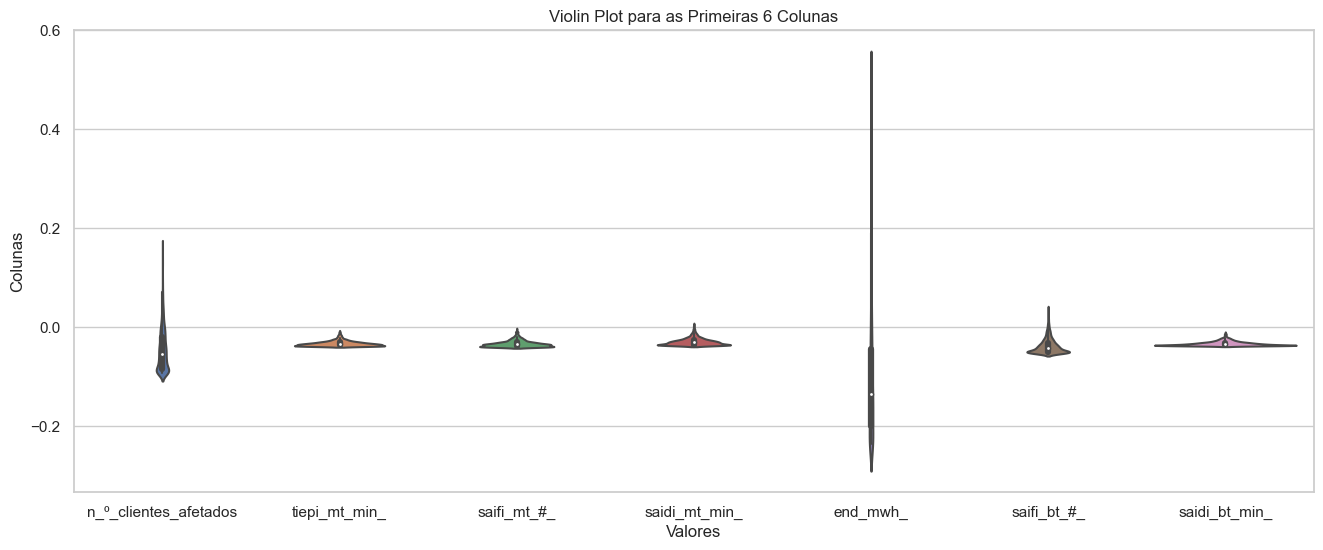

In [12]:
sns.set(style="whitegrid")

# Selecionar as colunas numéricas utilizando os índices
subset_quebras_final = QuebrasFinal.iloc[:, indices_col_numericas]

# Plotar violin plot para as primeiras 6 colunas
plt.figure(figsize=(16, 6))
sns.violinplot(data=subset_quebras_final)
plt.title("Violin Plot para as Primeiras 6 Colunas")
plt.xlabel("Valores")
plt.ylabel("Colunas")
plt.show()

# Modelling 

In [13]:
indices_col_numericas = QuebrasFinal.columns.get_indexer(colunas_numericas)

C:\Users\diogo\anaconda3\Lib\site-packages\omniplot\plot.py:106: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method=tree_method)


333 333
333 333
333 333


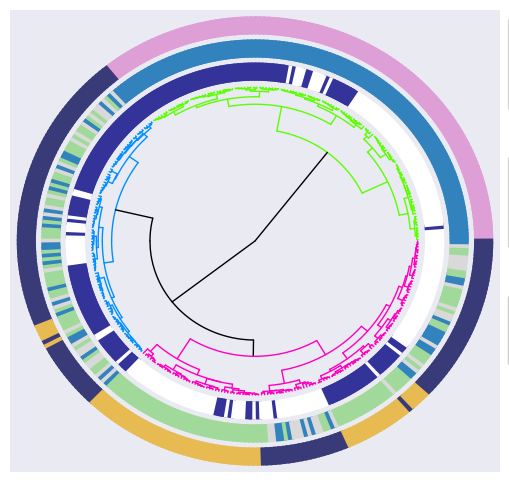

In [14]:
import seaborn as sns
from omniplot import plot as op
import matplotlib.pyplot as plt
df=sns.load_dataset("penguins")
df=df.dropna(axis=0)
res=op.radialtree(df, category=["species","island","sex"])
plt.show()

C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Win

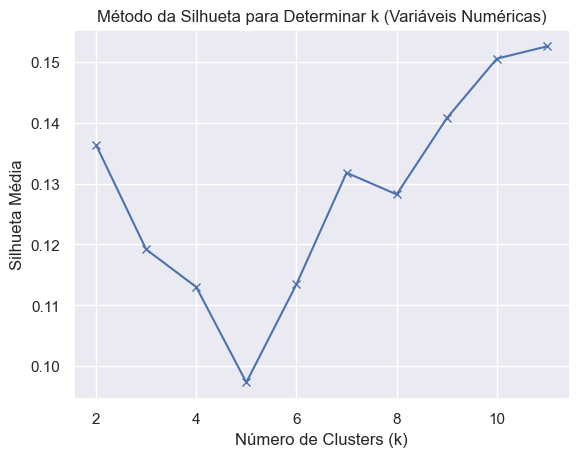

In [15]:
# Valores de k que você deseja testar
k_values = range(2, 12)

# Lista para armazenar os valores de silhueta média
silhouette_scores = []

# Iterar sobre os valores de k
for k in k_values:
    # Criar o modelo de clustering K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Treinar o modelo nos dados
    kmeans.fit(QuebrasFinal.iloc[:, indices_col_numericas])
    # Obter as etiquetas de cluster para cada ponto
    labels = kmeans.labels_
    # Calcular o score de silhueta
    silhouette_avg = silhouette_score(QuebrasFinal.iloc[:, indices_col_numericas], labels)
    # Armazenar o score de silhueta na lista
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico do Método do Cotovelo
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhueta Média')
plt.title('Método da Silhueta para Determinar k (Variáveis Numéricas)')
plt.show()


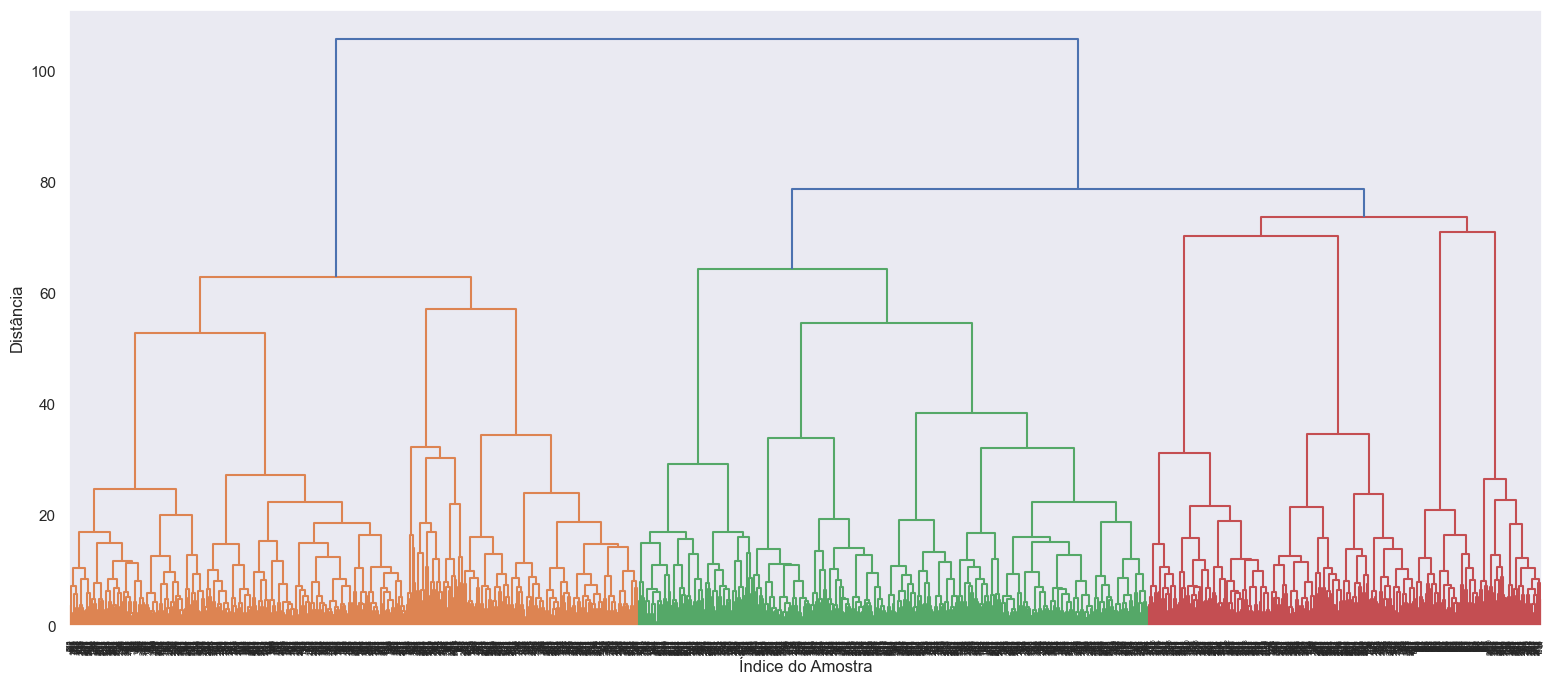

In [16]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model.fit(QuebrasFinal.iloc[:, indices_col_numericas])

# Função para plotar o dendrograma
def plot_dendrogram(model, **kwargs):
    # Calcula o layout do dendrograma
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # folha
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plota o dendrograma
    dendrogram(linkage_matrix, **kwargs)

# Plotando o dendrograma
plt.figure(figsize=(19, 8))
plot_dendrogram(model)
plt.xlabel('Índice do Amostra')
plt.ylabel('Distância')
plt.grid(False)
plt.savefig("DendogramaClustersQuebrasEnergeticas.png", format='png', bbox_inches='tight')
plt.show()


In [17]:
# Inicialize o modelo Agglomerative Clustering com o número desejado de clusters
n_clusters = 3  # Defina o número de clusters desejado
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Ajuste o modelo aos dados
agg_clustering.fit(QuebrasFinal.iloc[:, indices_col_numericas])

# Obtenha as etiquetas de cluster para cada amostra
cluster_labels = agg_clustering.labels_

# Apagar a coluna caso exista (corrir erro de colunas múltiplas)
if 'Cluster_Agglomerative' in QuebrasFinal.columns:
    QuebrasFinal.drop(columns=['Cluster_Agglomerative'], inplace=True)

# Adicione as etiquetas de cluster ao DataFrame QuebrasFinal
QuebrasFinal['Cluster_Agglomerative'] = cluster_labels

Silhouette média para o modelo Agglomerative Clustering: 0.09304848023176654


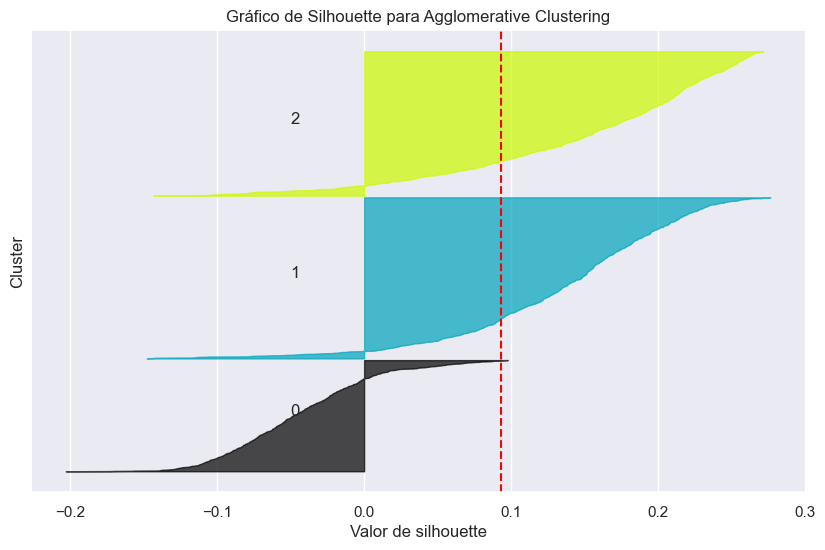

In [18]:
# Calcule a silhouette média para o modelo
silhouette_avg = silhouette_score(QuebrasFinal.iloc[:, indices_col_numericas], cluster_labels)
print("Silhouette média para o modelo Agglomerative Clustering:", silhouette_avg)

# Calcule a silhouette para cada amostra
sample_silhouette_values = silhouette_samples(QuebrasFinal.iloc[:, indices_col_numericas], cluster_labels)

# Crie um gráfico de barras para mostrar a silhouette para cada amostra
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(n_clusters):
    # Agregue a silhouette para amostras pertencentes ao cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Etiqueta do cluster no meio
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calcule o próximo y_lower para o próximo gráfico
    y_lower = y_upper + 10  

plt.title("Gráfico de Silhouette para Agglomerative Clustering")
plt.xlabel("Valor de silhouette")
plt.ylabel("Cluster")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")  # Linha para indicar a silhouette média
plt.yticks([])  # Limpe os yticks
plt.savefig("SilhuetaClustersQuebrasEnergeticas.svg",  format='svg', bbox_inches='tight')
plt.show()


In [19]:
QuebrasFinal["Cluster_Agglomerative"] = QuebrasFinal["Cluster_Agglomerative"].astype(int)
indices_col_numericas = np.append(indices_col_numericas, QuebrasFinal.shape[1] - 1)
QuebrasFinal

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,Cluster_Arredores das Grandes cidades,Cluster_Grandes Cidades,Cluster_Interior,Cluster_Litoral e ZonasIndustrias,Ser_BT?,Animais,Clima,Humanos - Acidentes,Humanos - Intenção,Cluster_Agglomerative
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,-0.274064,-0.069411,-0.036605,-0.038730,-0.035542,...,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641,0
1,EDPD_2018_JUN_T_20,ALMADA,2018-06-15,MT,Escavações,0.163957,-0.018786,-0.034361,-0.038733,-0.032607,...,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641,0
2,EDPD_2018_AGO_T_44,ALMADA,2018-08-30,MT,Escavações,-0.185190,0.008894,-0.034570,-0.038378,-0.034795,...,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641,0
3,EDPD_2018_SET_T_50,ALMADA,2018-09-10,MT,Escavações,-0.257136,-0.009043,-0.034326,-0.037660,-0.034405,...,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641,0
4,EDPD_2021_JAN_T_9,ALMADA,2021-01-08,MT,Inundações Imprevisíveis,0.843209,-0.038023,-0.032023,-0.039195,-0.032316,...,3.193024,-0.231803,-0.704930,-1.057067,-0.391884,-0.718573,2.697707,-0.983032,-0.222641,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678,EDPD_2020_MAI_T_33,MIRANDADODOURO,2020-05-21,MT,Intervenções À Superficie,-0.066692,-0.069439,-0.030230,-0.035614,-0.027559,...,-0.313183,-0.231803,1.418581,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641,2
2679,EDPD_2020_JUL_T_9,FIGUEIRADECASTELORODRIGO,2020-07-11,MT,Descarga Atmosférica Directa,0.293036,-0.090531,-0.032995,-0.036323,-0.023773,...,-0.313183,-0.231803,1.418581,-1.057067,-0.391884,-0.718573,2.697707,-0.983032,-0.222641,2
2680,EDPD_2020_AGO_T_26,FIGUEIRADECASTELORODRIGO,2020-08-27,MT,Aves,-0.346010,-0.092247,-0.038560,-0.039822,-0.036722,...,-0.313183,-0.231803,1.418581,-1.057067,-0.391884,1.391648,-0.370685,-0.983032,-0.222641,2
2681,EDPD_2020_AGO_T_14,SERNANCELHE,2020-08-06,MT,Risco Iminente Pessoas Ou Bens,0.216859,-0.077798,-0.035402,-0.037374,-0.028250,...,-0.313183,-0.231803,1.418581,-1.057067,-0.391884,-0.718573,-0.370685,1.017261,-0.222641,2


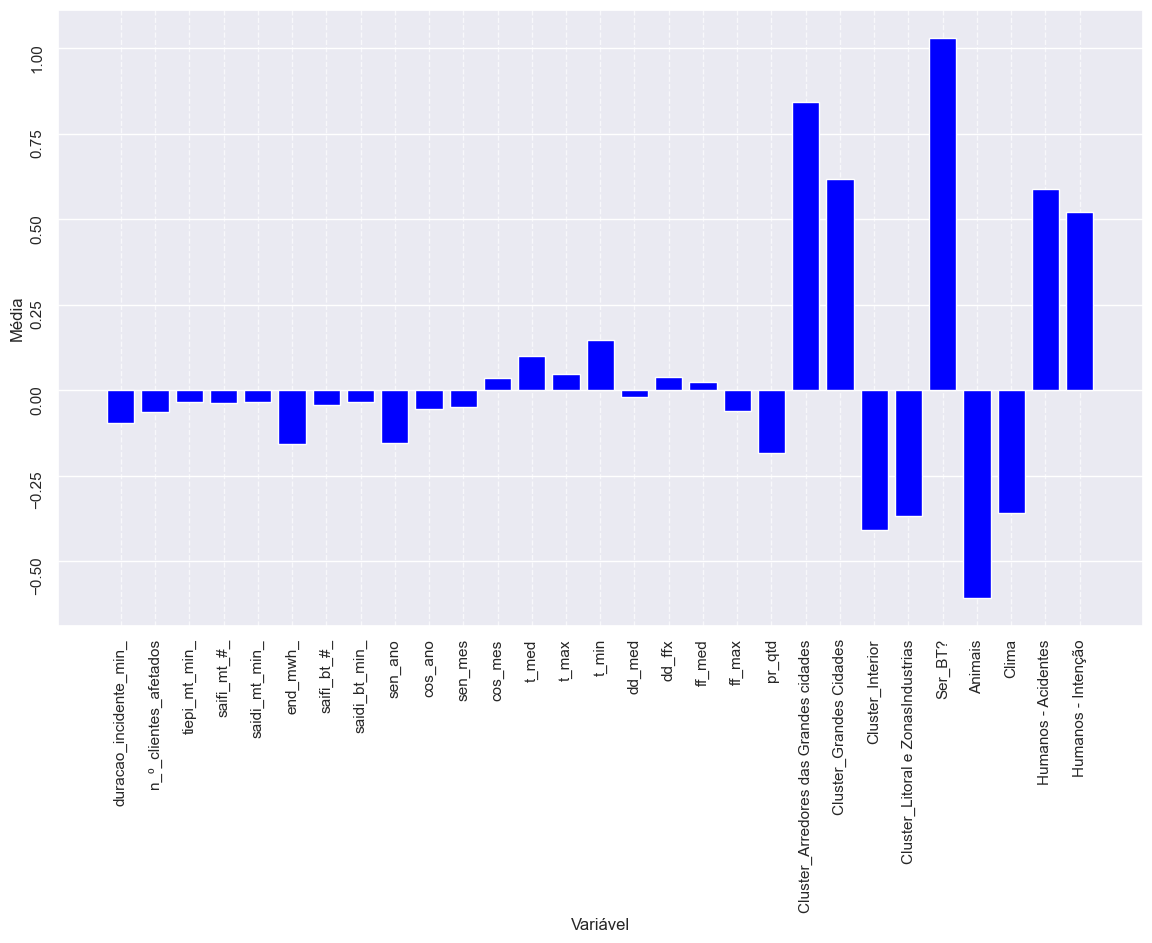

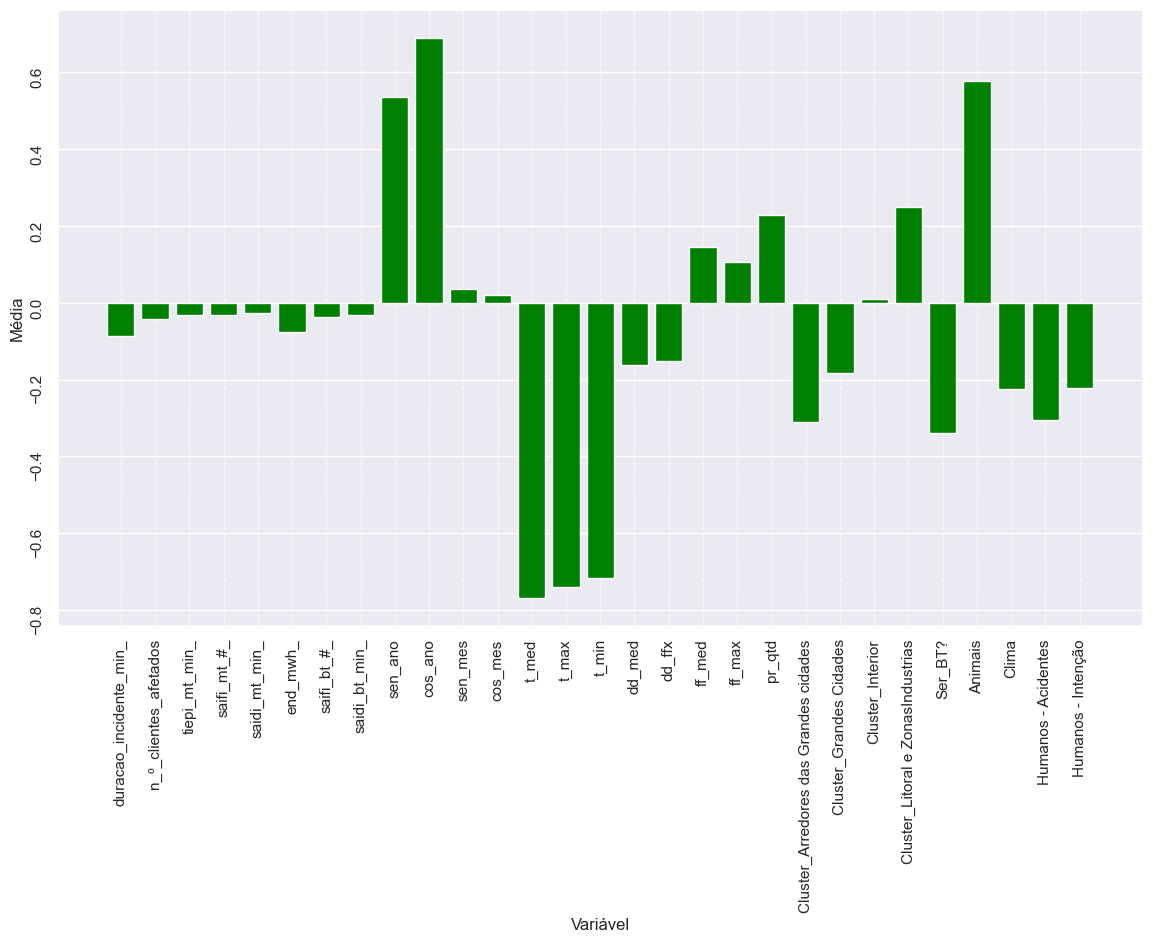

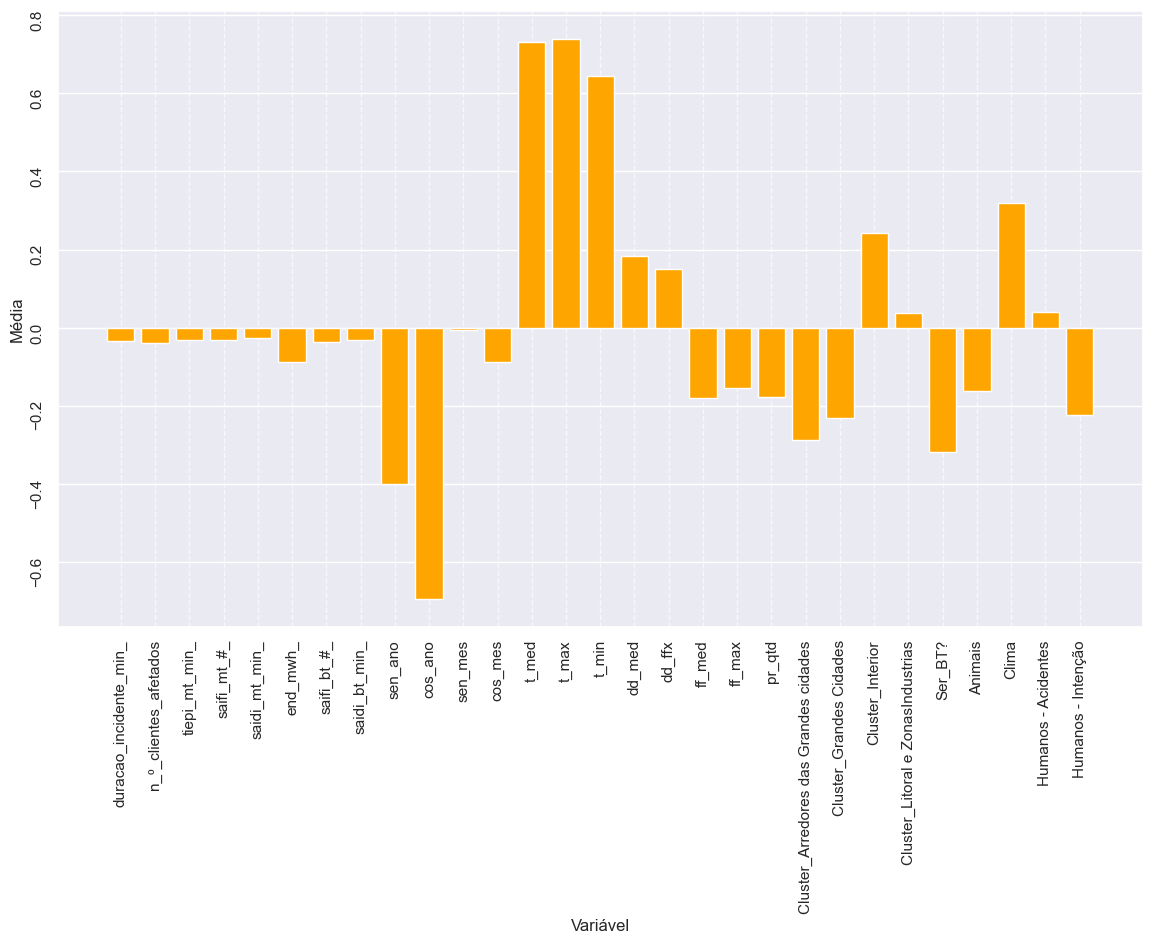

In [30]:
# Agrupar os dados por cluster e calcular as médias
cluster_means = QuebrasFinal.iloc[:, indices_col_numericas].groupby('Cluster_Agglomerative').mean()

# Definir cores para os clusters
colors = ['blue', 'green', 'orange', 'red', 'pink', 'black', 'yellow', 'purple', 'gray', 'turquoise', 'brown']

# Plotar os gráficos de barras para cada cluster
for i, cluster in enumerate(cluster_means.index):
    cluster_data = cluster_means.loc[cluster]
    plt.figure(figsize=(14, 8))
    plt.bar(cluster_data.index, cluster_data.values, color=colors[i])
    plt.ylabel('Média')
    plt.xlabel('Variável')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(rotation=90)
    plt.yticks(rotation=90)
    # Salvar figura
    plt.savefig(f"ClusterExplica{cluster}.svg", format='svg', bbox_inches='tight')
    plt.show()

In [21]:
# Criar a tabela pivô
pivot_table = QuebrasFinal.pivot_table(index='concelho', columns='Cluster_Agglomerative', aggfunc='size', fill_value=0)

# Renomear as colunas
pivot_table.columns = ['Cluster_' + str(col) for col in pivot_table.columns]

# Exibir a tabela pivô
pivot_table

,Cluster_0,Cluster_1,Cluster_2
concelho,,,
ABRANTES,2,9,7
AGUEDA,1,15,5
AGUIARDABEIRA,1,0,0
ALANDROAL,0,1,3
ALBERGARIAAVELHA,0,9,2
...,...,...,...
VILAVICOSA,0,3,6
VINHAIS,1,0,1
VISEU,6,20,13


In [22]:
file_path = shape_folder / "concelhos.shp"
Concelho = gpd.read_file(file_path)
Concelho.rename(columns={'NAME_1': 'Distrito'}, inplace=True)
Concelho.rename(columns={'NAME_2': 'concelho'}, inplace=True)
Concelho["concelho"] = Concelho["concelho"].str.upper()

def remover_pontuacao(text):
    text = text.replace('Ç', 'C').replace('Ã', 'A').replace('É', 'E').replace('Â', 'A').replace('Ô', 'O').replace('Á', 'A').replace('Ú', 'U').replace('Ê', 'E').replace('Ó', 'O').replace('Í', 'I')
    return text

Concelho["concelho"] = Concelho["concelho"].apply(remover_pontuacao)
Concelho["concelho"] = Concelho["concelho"].str.replace('-', ' ')
Concelho["concelho"] = Concelho["concelho"].str.replace(' ', '')

Concelho = Concelho[~Concelho['Distrito'].isin(['Azores', 'Madeira'])].reset_index(drop = True)
Concelho

,ID_0,ISO,NAME_0,ID_1,Distrito,ID_2,concelho,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,182,PRT,Portugal,1,Évora,1,EVORA,PT.EV.EV,0,0705,Concelho,Municipality,None,None,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506..."
1,182,PRT,Portugal,1,Évora,2,ALANDROAL,PT.EV.AL,0,0701,Concelho,Municipality,None,None,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343..."
2,182,PRT,Portugal,1,Évora,3,ARRAIOLOS,PT.EV.AR,0,0702,Concelho,Municipality,None,None,"POLYGON ((-7.88611 38.92495, -7.88580 38.92472..."
3,182,PRT,Portugal,1,Évora,4,BORBA,PT.EV.BO,0,0703,Concelho,Municipality,None,None,"POLYGON ((-7.46362 38.92344, -7.46344 38.92329..."
4,182,PRT,Portugal,1,Évora,5,ESTREMOZ,PT.EV.ES,0,0704,Concelho,Municipality,None,None,"POLYGON ((-7.52770 39.00080, -7.52765 39.00066..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,182,PRT,Portugal,20,Viseu,302,TAROUCA,PT.VI.TR,0,1820,Concelho,Municipality,None,None,"POLYGON ((-7.72591 41.08079, -7.72442 41.08028..."
274,182,PRT,Portugal,20,Viseu,303,TONDELA,PT.VI.TO,0,1821,Concelho,Municipality,None,None,"POLYGON ((-8.12772 40.64028, -8.12751 40.64027..."
275,182,PRT,Portugal,20,Viseu,304,VILANOVADEPAIVA,PT.VI.VP,0,1822,Concelho,Municipality,None,None,"POLYGON ((-7.77933 40.93439, -7.77835 40.93436..."
276,182,PRT,Portugal,20,Viseu,305,VISEU,PT.VI.VS,0,1823,Concelho,Municipality,None,None,"POLYGON ((-7.80686 40.83789, -7.80653 40.83787..."


In [23]:
Freguesias_com_clusters = Concelho.merge(pivot_table, left_on='concelho', right_index=True, how="left")
Freguesias_com_clusters.fillna(0, inplace=True)
Freguesias_com_clusters

,ID_0,ISO,NAME_0,ID_1,Distrito,ID_2,concelho,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry,Cluster_0,Cluster_1,Cluster_2
0,182,PRT,Portugal,1,Évora,1,EVORA,PT.EV.EV,0,0705,Concelho,Municipality,0,0,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506...",2.0,13.0,16.0
1,182,PRT,Portugal,1,Évora,2,ALANDROAL,PT.EV.AL,0,0701,Concelho,Municipality,0,0,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343...",0.0,1.0,3.0
2,182,PRT,Portugal,1,Évora,3,ARRAIOLOS,PT.EV.AR,0,0702,Concelho,Municipality,0,0,"POLYGON ((-7.88611 38.92495, -7.88580 38.92472...",0.0,6.0,6.0
3,182,PRT,Portugal,1,Évora,4,BORBA,PT.EV.BO,0,0703,Concelho,Municipality,0,0,"POLYGON ((-7.46362 38.92344, -7.46344 38.92329...",0.0,0.0,3.0
4,182,PRT,Portugal,1,Évora,5,ESTREMOZ,PT.EV.ES,0,0704,Concelho,Municipality,0,0,"POLYGON ((-7.52770 39.00080, -7.52765 39.00066...",0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,182,PRT,Portugal,20,Viseu,302,TAROUCA,PT.VI.TR,0,1820,Concelho,Municipality,0,0,"POLYGON ((-7.72591 41.08079, -7.72442 41.08028...",0.0,0.0,0.0
274,182,PRT,Portugal,20,Viseu,303,TONDELA,PT.VI.TO,0,1821,Concelho,Municipality,0,0,"POLYGON ((-8.12772 40.64028, -8.12751 40.64027...",3.0,10.0,3.0
275,182,PRT,Portugal,20,Viseu,304,VILANOVADEPAIVA,PT.VI.VP,0,1822,Concelho,Municipality,0,0,"POLYGON ((-7.77933 40.93439, -7.77835 40.93436...",2.0,1.0,1.0
276,182,PRT,Portugal,20,Viseu,305,VISEU,PT.VI.VS,0,1823,Concelho,Municipality,0,0,"POLYGON ((-7.80686 40.83789, -7.80653 40.83787...",6.0,20.0,13.0


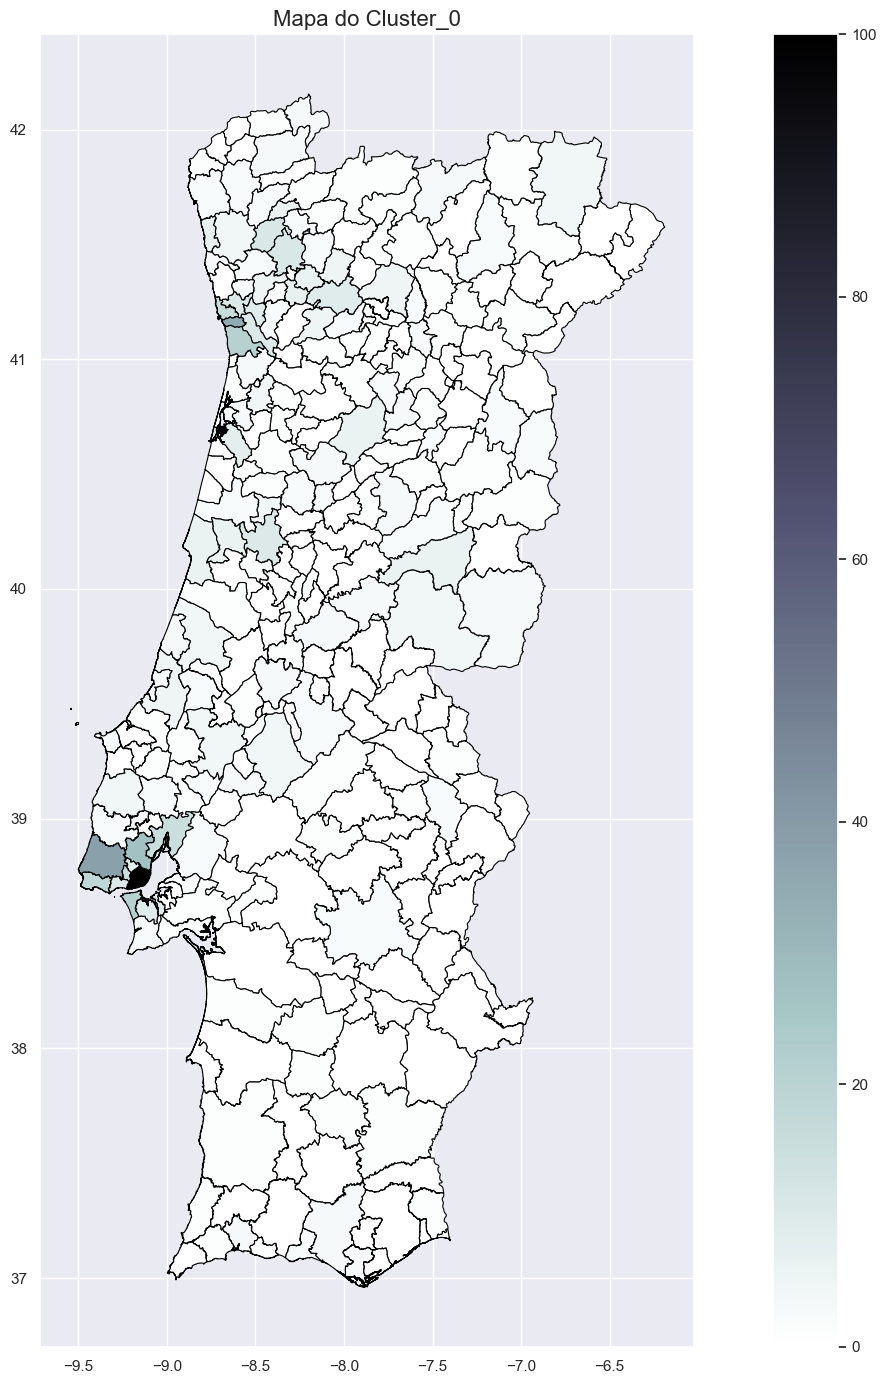

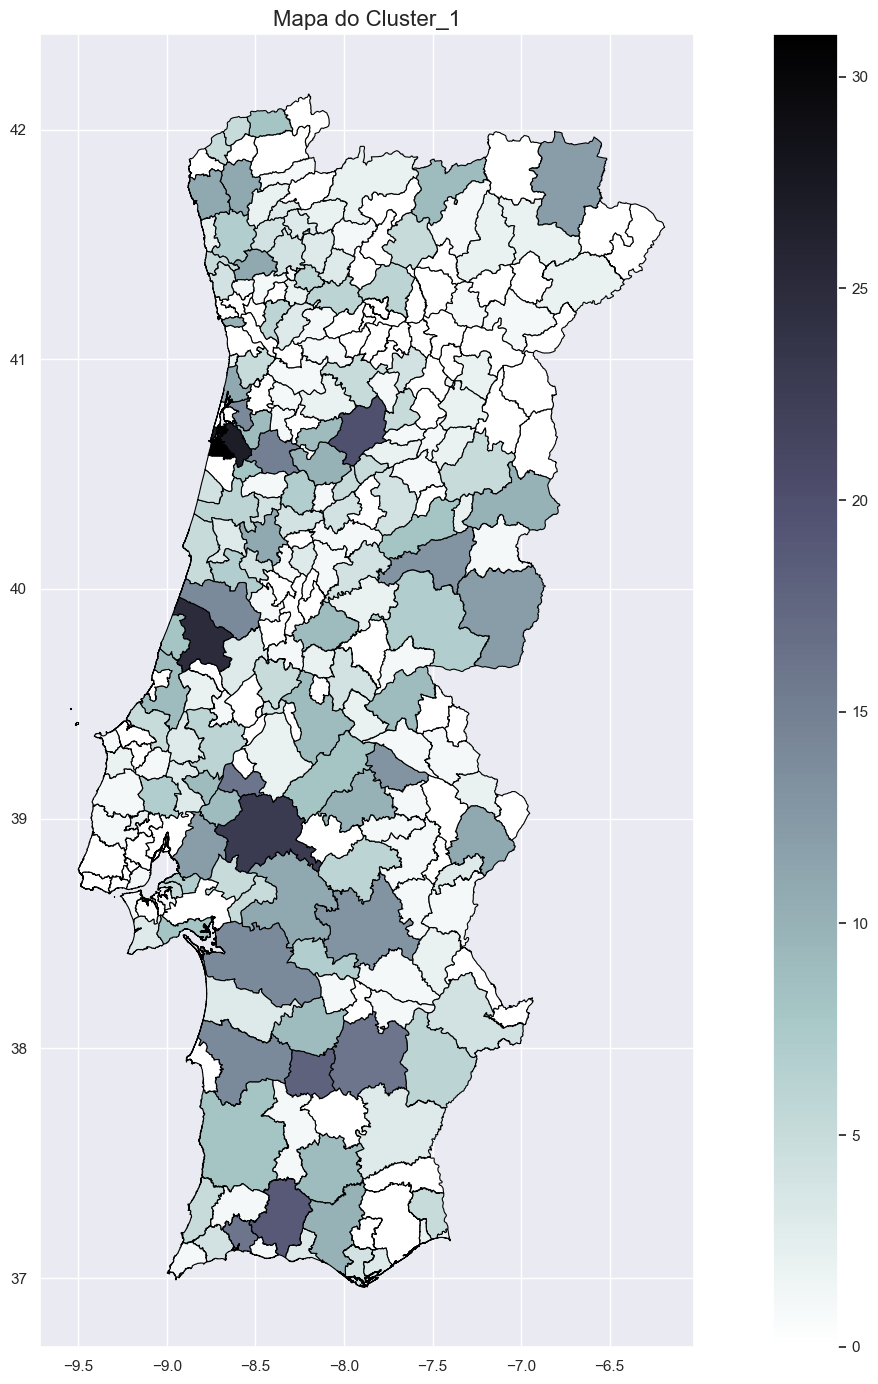

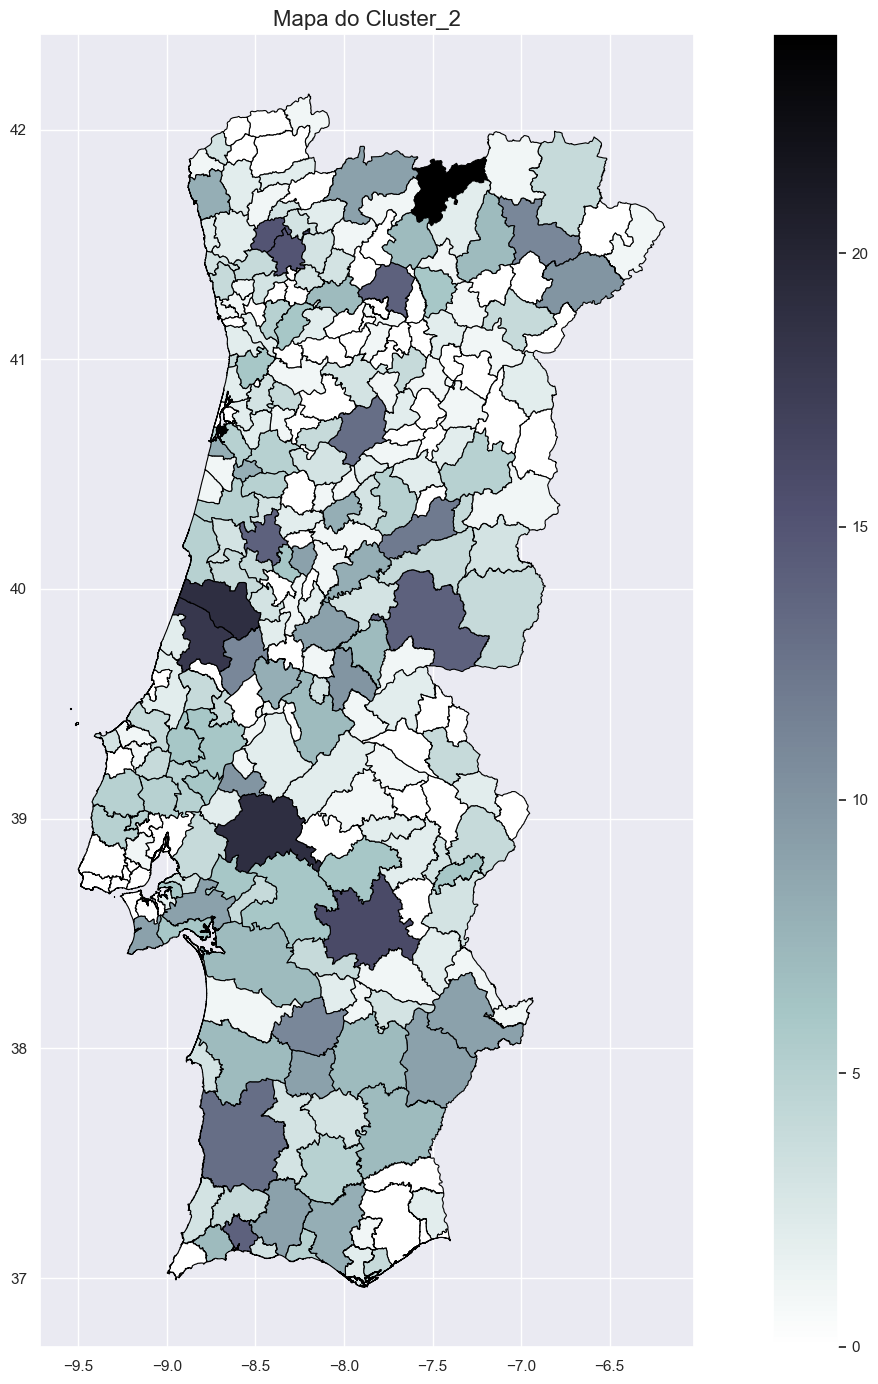

In [24]:
# Filtrar as colunas do DataFrame que contenham "Cluster"
cluster_columns = [col for col in Freguesias_com_clusters.columns if 'Cluster' in col]

# Iterar sobre as colunas de clusters e plotar os mapas
for cluster_column in cluster_columns:
    # Configurar a figura e os eixos para o mapa
    fig, ax = plt.subplots(figsize=(16, 14))
    
    # Plotar o mapa das freguesias
    Freguesias_com_clusters.plot(column=cluster_column, cmap='bone_r', linewidth=0.8, edgecolor='black', legend=True, ax=ax)
    
    # Adicionar título
    ax.set_title(f'Mapa do {cluster_column}', fontsize=16)
    
    # Ajustar o layout
    plt.tight_layout()

    # Salvar figura
    plt.savefig(f"ClusterQuebra{cluster_column}.png", format='png', bbox_inches='tight')
    
    # Exibir o gráfico
    plt.show()
